<a href="https://colab.research.google.com/github/COFAlumni-USB/Physics-REBoot-Applied-Science-Bootcamp/blob/main/Hands%20On/Dia%205/Bayes_senal_ruidosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
<img src='https://static.wixstatic.com/media/42c521_9ece3ec976e541fdb6ff48e2774e6586~mv2.png/v1/fill/w_735,h_284,al_c,q_85,usm_0.66_1.00_0.01/20210615_cofalumni_bootcamp1.webp' width="800" />
</p>


## Physics Research and Education Bootcamp - Computational | Episode 1

**Created**: Jun.21, 2021

**Last Modification**: Jun.21, 2021

**License**: http://www.apache.org/licenses/LICENSE-2.0

# Preámbulo

Primero veamos que debemos cargar los paquetes de Python necesarios para trabajar.

In [1]:
import numpy as np # importa la libreria de numpy
import matplotlib.pyplot as plt # importa la libreria de matplotlib
np.random.seed(1337) # establece un semilla para generacion aleatoria de numeros


# ***Reconstruccion de parametros usando Análisis Bayesiano***
\\
En esta ocasión, usaremos los conocimientos que hemos adquirido sobre análisis bayesiano para reconstruir los parámetros de una señal sinusoidal producida por un generador de funciones, la cual lamentablemente funciona de manera intermitente introduciendo ruido en la señal, que genera a su vez incertidumbre acerca de la frecuencia de la misma.

Para nuestro modelo, asumiremos que el ruido en la señal sigue una distribución "Normal", denotada por $\mathcal{N}$. El modelo en cuestión se puede escribir matemáticamente de la siguiente manera:

\begin{align}
y(x,\omega,\epsilon) &= A*sin(\omega\,x) + \epsilon .\\
\end{align}

Donde $\epsilon = \mathcal{N}(\mu,\sigma^{2})$ es el error introducido a la señal siguiendo nuestra distribución, $\omega$ es la frecuencia de la señal, $A$ es la amplitud de la señal, $\mu$ el nivel de ruido y $\sigma^{2}$ la desviación estándar de ese ruido.




In [18]:
def modelo(x,frec,err):
    '''
   Definimos el modelo.

  Parametros
  x (lista o array):
  frec (flotante):
  err (flotante):

  Resultado
  Ecuacion (2) (flotante)


    '''
    # Definimos el modelo
    return np.sin(frec*x) + err

Para este caso, no es factible reparar el generador ya que es necesario usarlo a muy corto plazo para algunos experimentos y no tenemos un generador de reemplazo. Nuestra mejor opción es aplicar las herramientas que hemos aprendido y estimar la frecuencia y el nivel del ruido en la señal, y de esa manera corregir luego los resultados que obtengamos en los experimentos para los cuales usemos este generador.

Como siempre empezamos la implementacion computacional definiendo las librerias que usaremos

Para empezar, simulamos un experimento en el cual algunos tomamos algunas mediciones del output del generador:

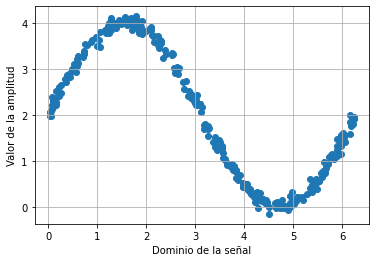

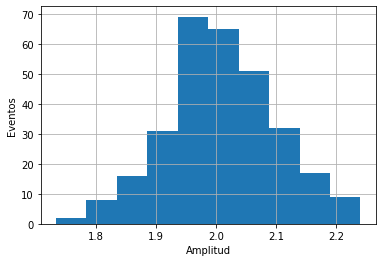

In [27]:
# definamos algunas variables generales para nuestra solucion
N_muestras = 300 # numero de muestras
Frecuencia = 1 # valor de frecuencia
Amplitud = 2 #valor de amplitud

# construyamos nuestra senal
x = np.random.random(N_muestras)*2*np.pi # genera N_muestras de numeros aleatorios con probabilidad uniforme con un factor de 2pi
error = np.random.normal(2,scale=0.1,size=N_muestras) # genera N_muestras de numeros aleatorios siguiendo una probabilidad generada por una distribucion normal centrada en 2
y = Amplitud*np.sin(Frecuencia * x) + error # valor de la senal con valor del error incluido

# Observamos la señal y la distribucion de los errores
plt.figure() # genera una figura donde colocaremos nuestro grafico
plt.scatter(x,y) # crea un grafico con los valores de coordenadas X,Y del valor de la senal
plt.grid(True) # activa el grid de escala en grafico de python
plt.xlabel('Dominio de la señal')
plt.ylabel('Valor de la amplitud')

plt.figure() # genera la figura donde colocaremos nuestros graficos
plt.hist(error) # genera los histogramas de los valores de las senales
plt.xlabel('Amplitud')
plt.ylabel('Eventos')
plt.grid(True) # activa grid de escala en el grafico de python

Existen muchas maneras de atacar este problema. Afortunadamente, a través de aplicar el teorema de Bayes [<a href="https://es.wikipedia.org/wiki/Teorema_de_Bayes">1</a>], podemos determinar los parametros de nuestro modelo de señal. 

Explícitamente, la solución de este problema es la *densidad de probabilidad posterior* $p(\omega,\epsilon|y)$, la cual evaluaremos a partir de probabilidades de densidad a priori que definiremos sobre los parámetros del modelo. En otras palabras esto se representa por la siguiente relación matemática:

\begin{equation}
p(\omega,\epsilon|y) \propto p(y|\omega,\epsilon) * p(\omega,\epsilon).\tag{1}
\end{equation}

De este modo, usaremos una distribución normal para describir la *verosimilitud* $p(y|\omega,\epsilon)$:

\begin{equation}
p(y|\omega,\epsilon) = \prod_{i}^{N_{\text{obs}}} \text{exp}\left(-\frac{[y_{\text{obs}}(x_i) - y(x_{i},\omega,\epsilon)]^{2}}{2\gamma^{2}}
\right).\tag{2}
\end{equation}
Donde $\gamma$ es un parámetro que fijaremos y que se encarga de modular el rango de distancias entre las mediciones y el muestreo que consideraremos viable para el análisis, tipicamente toma un valor entre $(0,1]$.

Definimos entonces la función en Python de la *verosimilitud* dada por la ecuación (2):

In [24]:
def verosimilitud(x,m,des_estandar):
    '''
    Describimos la función de verosimilitud, la cual corresponde a una distribución Normal.

    Parametros
    x (lista o array):
    m (flotante):
    des_estandar (flotante):

    Resultado
    Ecuacion (2) (flotante)


    '''
    ver = np.exp(-(x-m)**2/(2*(des_estandar**2)))
    return np.prod(ver)


In [25]:
def Probabilidad_posterior(x,y,d_estandard,muestras):
    # Generamos un muestreo simulando funciones de probabilidad uniformes en el intervalo [0,5]
    # para la Frecuencia y el Error de la señal
    Prior_frec = np.linspace(0,5,muestras) #np.random.random(muestras)*5
    Prior_err = np.linspace(0,5,muestras) #np.random.random(muestras)*0.01
    Frec, Err = np.meshgrid(Prior_frec,Prior_err)
    # Calculamos la probabilidad a posteriori
    Posterior = np.zeros((muestras,muestras))
    for i in range(muestras):
        for j in range(muestras):
            Posterior[i][j] = verosimilitud(modelo(x,Frec[i][j],Err[i][j]),y,d_estandard)
    return Posterior,Frec,Err

def Marginalizar_y_plotear_posterior(Posterior,Frec,Err):
    # Marginalizamos la distribución Posterior conjunta para cada una de las variables,
    # esto lo hacemos integrando (sumando sobre las variables alternas a la variable
    # de interés)
    Marginal_Frec = np.sum(Posterior,axis=0)*(Err[1][0]-Err[0][0])
    Marginal_Error = np.sum(Posterior,axis=1)*(Frec[0][1]-Frec[0][0])
  

  # graficando los resultados

    plt.figure()
    plt.suptitle('Distribución Posterior Conjunta',fontweight='bold')
    plt.contourf(Frec,Err,Posterior)
    plt.xlabel('Frecuencia',fontweight='bold')
    plt.ylabel('Error',fontweight='bold')
    plt.grid(True)

    plt.figure()
    plt.suptitle('Distribución Marginal Posterior del Error',fontweight='bold')
    plt.plot(Err[:,0],Marginal_Error)
    plt.xlabel('Error',fontweight='bold')
    plt.ylabel('Probabilidad',fontweight='bold')
    plt.grid(True)

    plt.figure()
    plt.suptitle('Distribución Marginal Posterior de la Frecuencia',fontweight='bold')
    plt.plot(Frec[0,:],Marginal_Frec)
    plt.xlabel('Frecuencia',fontweight='bold')
    plt.ylabel('Probabilidad',fontweight='bold')
    plt.grid(True)



A través del muestreo aleatorio a partir de distribuciones uniformes evaluamos el problema en la celda a continuación.

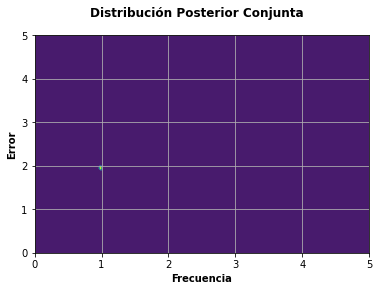

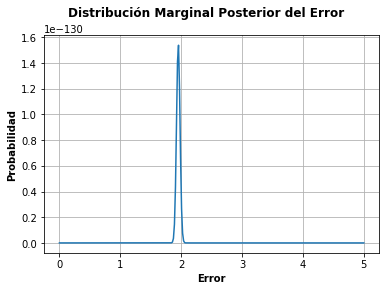

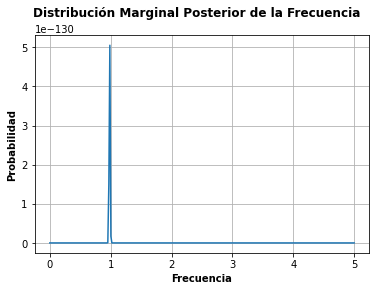

In [28]:
Muestras = 300 # numero de muestras
gamma = 0.5 # parametro de ajuste del modelo
P,frec,err = Probabilidad_posterior(x,y,gamma,Muestras)

# Graficamos la distribucion de probabilidad conjunta posterior. Las areas de mayor
# intensidad de color indican una mayor probabilidad para los parametros del modelo
Marginalizar_y_plotear_posterior(P,frec,err)


Ahora que ya hemos visto estos casos sencillos, Comprueba tu código utilizando distintos valores de frecuencia, error y número de muestras como por ejemplo:

*   Número de muestras = $3,...,100$
*   $\epsilon = \mathcal{N}(\{0,...,3\},\{1,...,3\})$
*   $\omega = \{\frac{1}{4},...,10\}$

¡Intenta explicar los resultados!





<div class="alert alert-block alert-info">

**Nota** : 
    
(Una de las principales conclusiones al incluir mas observaciones es justamente el fundamento del análisis bayesiano: a medida que existen más observaciones que proporcionan información suficiente, el estimado a *posteriori* mejora considerablemente el resultado final).*italicized text*

</div>

Versión: **1.0** Antonio Figueroa (), Manuel Morgado (morgadovargas@unistra.fr)

Versiones de paquetes de python

In [8]:
#libs summary
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins', 'builtins', 'numpy', 'matplotlib.pyplot', 'types']